In [1]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

In [2]:
circuit = Circuit('Resistor Bridge')

circuit.V('input', 1, circuit.gnd, 10@u_V)
circuit.R(1, 1, 2, 2@u_kΩ)
circuit.R(2, 1, 3, 1@u_kΩ)
circuit.R(3, 2, circuit.gnd, 1@u_kΩ)
circuit.R(4, 3, circuit.gnd, 2@u_kΩ)
circuit.R(5, 3, 2, 2@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()

for node in analysis.nodes.values():
    print('Node {}: {:4.1f} V'.format(str(node), float(node))) # Fixme: format value + unit

Node 3:  6.0 V
Node 2:  4.0 V
Node 1: 10.0 V


In [3]:
import PySpice as ps 
print(ps.__version__)

1.4.3


In [4]:
import math

import matplotlib.pyplot as plt

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
from PySpice.Unit import *

class SineSource(NgSpiceShared):
    def __init__(self, amplitude, frequency, **kwargs):
        super().__init__(**kwargs)
        self._amplitude = amplitude
        self._pulsation = float(frequency.pulsation)

    def get_vsrc_data(self, voltage, time, node, ngspice_id):
        voltage[0] = self._amplitude * math.sin(self._pulsation * time)
        return 0

class CosineSource(NgSpiceShared):
    def __init__(self, amplitude, frequency, **kwargs):
        super().__init__(**kwargs)
        self._amplitude = amplitude
        self._pulsation = float(frequency.pulsation)

    def get_vsrc_data(self, voltage, time, node, ngspice_id):
        voltage[0] = self._amplitude * math.cos(self._pulsation * time)
        return 0

circuit = Circuit('Voltage Divider')

circuit.V('input', 'input', circuit.gnd, 'dc 0 external')
circuit.R(1, 'input', 'output', 10@u_kΩ)
circuit.R(2, 'output', circuit.gnd, 1@u_kΩ)

amplitude = 10@u_V
frequency = 50@u_Hz
ngspice_shared = SineSource(amplitude=amplitude, frequency=frequency, send_data=False)
simulator = circuit.simulator(temperature=25, nominal_temperature=25,
                              simulator='shared', ngspice_shared=ngspice_shared)
period = float(frequency.period)
analysis = simulator.transient(step_time=period/200, end_time=period*2)

# [Do stuff with analysis...]

ngspice_shared = CosineSource(amplitude=amplitude, frequency=frequency, send_data=False)
simulator = circuit.simulator(temperature=25, nominal_temperature=25,
                              simulator='shared', ngspice_shared=ngspice_shared)
period = float(frequency.period)
analysis = simulator.transient(step_time=period/200, end_time=period*2)


ValueError: Unknown simulator type

In [10]:
import matplotlib.pyplot as plt
import os

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


libraries_path = find_libraries()


In [6]:
spice_library = SpiceLibrary(libraries_path)

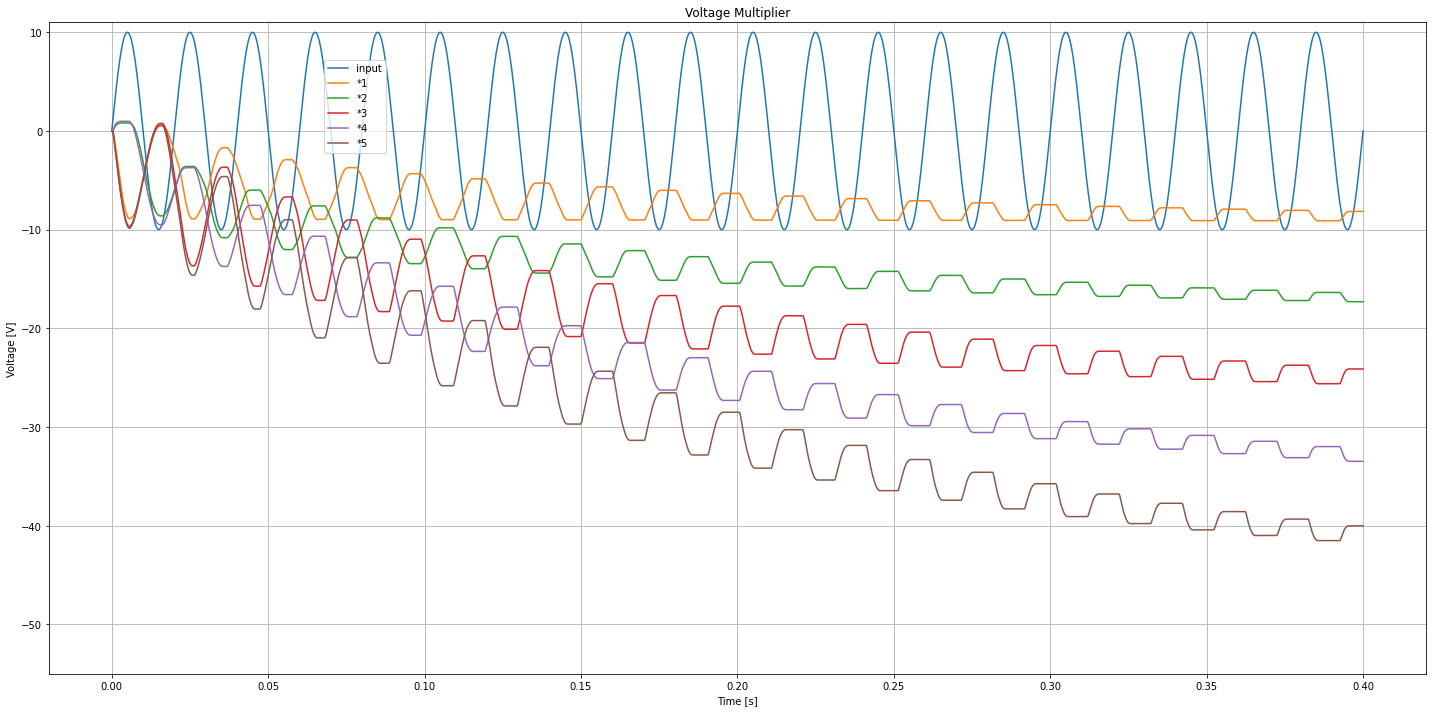

In [13]:


#libraries_path = os.path.join(os.environ['/data/home/marbella/pyspice-examples/PySpice-1.4.3/examples/'], 'libraries')
libraries_path = '/data/home/marbella/pyspice-examples/PySpice-1.4.3/examples/libraries'
spice_library = SpiceLibrary(libraries_path)

circuit = Circuit('Voltage Multiplier')
circuit.include(spice_library['1N4148'])

source = circuit.SinusoidalVoltageSource('input', 'in', circuit.gnd, amplitude=10@u_V, frequency=50@u_Hz)

multiplier = 5
for i in range(multiplier):
    if i:
        top_node = i - 1
    else:
        top_node = 'in'
    midlle_node, bottom_node = i + 1, i
    circuit.C(i, top_node, midlle_node, 1@u_mF)
    circuit.X(i, '1N4148', midlle_node, bottom_node)
circuit.R(1, multiplier, multiplier+1, 1@u_MΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=source.period/200, end_time=source.period*20)


figure = plt.figure(1, (20, 10))

axe = plt.subplot(111)
axe.set_title('Voltage Multiplier')
axe.set_xlabel('Time [s]')
axe.set_ylabel('Voltage [V]')
axe.grid()
# Fixme: axis vs axe ...
plot(analysis['in'], axis=axe)
for i in range(1, multiplier+1):
    y = analysis[str(i)]
    if i & 1: # for odd multiplier the ground is permuted
        y -= analysis['in']
    plot(y, axis=axe)
# axe.axhline(-multiplier*source.amplitude)
axe.set_ylim(float(-multiplier*1.1*source.amplitude), float(1.1*source.amplitude))
axe.legend(['input'] + ['*' + str(i) for i in range(1, multiplier+1)] ,
           loc=(.2,.8))

plt.tight_layout()
plt.show()

In [16]:
8*8*8

512

###### 

In [9]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *


class Level2(SubCircuitFactory):
    __name__ = 'level2'
    __nodes__ = ('d4', 'g4', 'v4')
    def __init__(self):
        super().__init__()
        self.M(1, 'd4', 'g4', 'v4', 'v4', model='nmos', w=1e-5, l=3.5e-7)

class Level1(SubCircuitFactory):
    __name__ = 'level1'
    __nodes__ = ('d3', 'g3', 'v3')
    def __init__(self):
        super().__init__()
        self.X('mos2', 'level2', 'd3', 'g3', 'v3')
        self.subcircuit(Level2())

circuit = Circuit('Transistor output characteristics')
circuit.V('dd', 'd1', circuit.gnd, 2)
circuit.V('ss', 'vsss', circuit.gnd, 0)
circuit.V('sig', 'g1', 'vsss', 0)
circuit.X('mos1', 'level1', 'd1', 'g1', 'vsss')

if True:
    circuit.subcircuit(Level1())
else:
    subcircuit_level2 = SubCircuit('level2', 'd4', 'g4', 'v4')
    subcircuit_level2.M(1, 'd4', 'g4', 'v4', 'v4', model='nmos', w=1e-5, l=3.5e-7)

    subcircuit_level1 = SubCircuit('level1', 'd3', 'g3', 'v3')
    subcircuit_level1.X('mos2', 'level2', 'd3', 'g3', 'v3')
    subcircuit_level1.subcircuit(subcircuit_level2)

    circuit.subcircuit(subcircuit_level1)

print(str(circuit))


simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(Vdd=slice(0, 5, .1)) # Fixme: ,Vsig=slice(1, 5, 1)

.title Transistor output characteristics
.subckt level1 d3 g3 v3
.subckt level2 d4 g4 v4
M1 d4 g4 v4 v4 nmos l=3.5e-07 w=1e-05
.ends level2
Xmos2 d3 g3 v3 level2
.ends level1
Vdd d1 0 2
Vss vsss 0 0
Vsig g1 vsss 0
Xmos1 d1 g1 vsss level1



NameError: Simulation failed